In [1]:
import pandas as pd
import glob
import pendulum 
import pandas as pd
from tqdm import tqdm
import json

from scipy.optimize import curve_fit
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Upload latest data

In [3]:
positive_posts = pd.read_csv('./data/Aprovação_14.zip')
positive_posts.shape

(4288, 9)

# Simple analyses + Platform selection

In [4]:
# Filter posts for the specified platform
platform = 'Instagram'

positive_posts_p = positive_posts[positive_posts['platform'] == platform].copy()

# Remove duplicate rows
positive_posts_p.drop_duplicates(inplace=True)

# Drop duplicates based on specific columns (in this case 'post_id')
positive_posts_p = positive_posts_p.drop_duplicates(subset=['post_id'])


# Sort posts by date
positive_posts_p = positive_posts_p.sort_values(by='dt')

# Convert 'post_id' to an integer type if platform is 'Facebook'
if platform == 'Facebook':
    positive_posts_p['post_id'] = positive_posts_p['post_id'].astype(float).astype(int)

positive_posts_p.shape


(2785, 9)

In [5]:
df = positive_posts_p.groupby('new_candidate')['post_id'].count().reset_index(name='post_count')
df['c'] = np.cumsum(df.post_count)
df

,new_candidate,post_count,c
0,André Fernandes,377,377
1,Capitão Wagner,267,644
2,Evandro Leitão,1095,1739
3,José Sarto,1046,2785


In [6]:
positive_posts_p.groupby('new_candidate')['likeCount'].sum()

new_candidate
André Fernandes    1756050.0
Capitão Wagner      244855.0
Evandro Leitão     1081453.0
José Sarto         1181102.0
Name: likeCount, dtype: float64

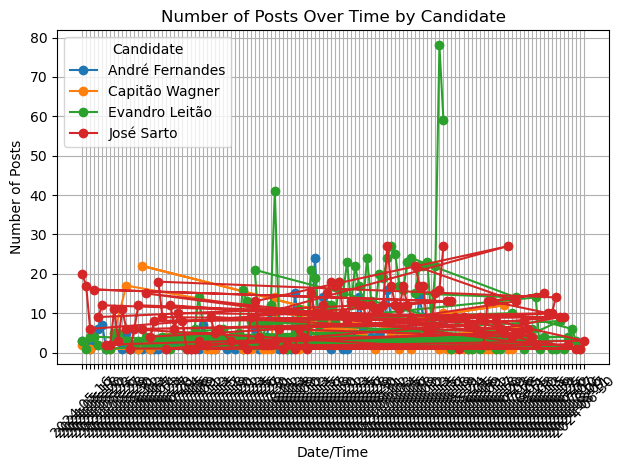

In [7]:
# Group by 'new_candidate' and 'dt', then count the number of posts for each group
grouped_data = positive_posts_p.groupby(['new_candidate', 'dt']).size().reset_index(name='post_count')

# Plotting
for candidate, group_data in grouped_data.groupby('new_candidate'):
    # Plot the number of posts over time for each candidate
    plt.plot(group_data['dt'], group_data['post_count'], marker='o', label=candidate)
    
# Display the plot with enhancements
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)           # Add grid lines for better visual interpretation
plt.legend(title='Candidate')  # Add a legend with a title
plt.xlabel('Date/Time')  # Label for the x-axis
plt.ylabel('Number of Posts') # Label for the y-axis
plt.title('Number of Posts Over Time by Candidate') # Title of the plot
plt.tight_layout() 

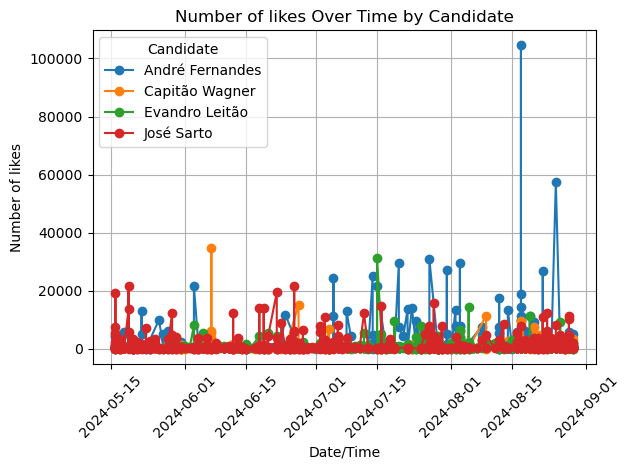

In [8]:
for candidate, group_data in positive_posts_p.groupby('new_candidate'):
    plt.plot(group_data['dt'], group_data['likeCount'], marker='o', label=candidate)

# Display the plot with enhancements
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)           # Add grid lines for better visual interpretation
plt.legend(title='Candidate')  # Add a legend with a title
plt.xlabel('Date/Time')  # Label for the x-axis
plt.ylabel('Number of likes') # Label for the y-axis
plt.title('Number of likes Over Time by Candidate') # Title of the plot
plt.tight_layout()

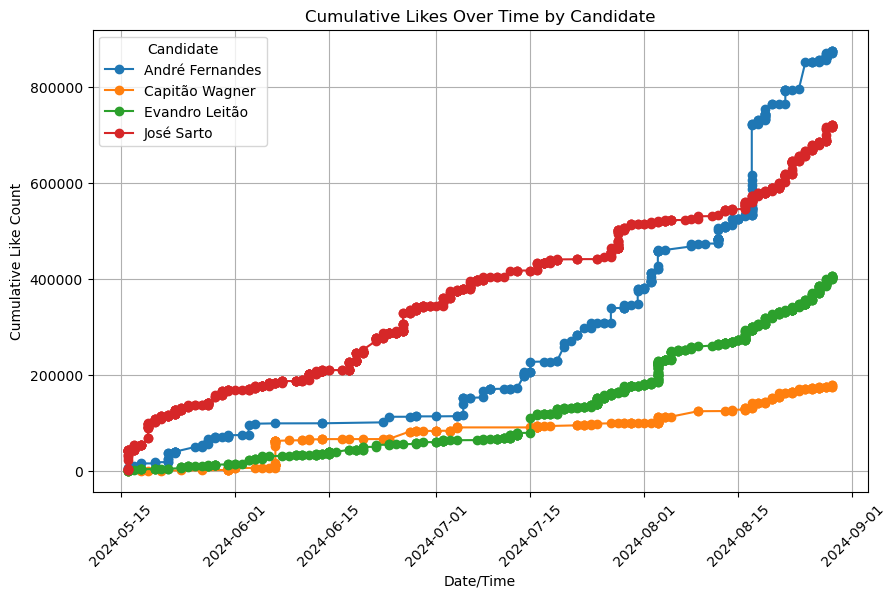

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'positive_posts_p' contains the data and 'dt' is already in datetime format

# Compute the cumulative sum of 'likeCount' grouped by 'new_candidate'
positive_posts_p['cumsum_likeCount'] = positive_posts_p.groupby('new_candidate')['likeCount'].cumsum()

# Create the line plot
plt.figure(figsize=(10, 6))

# Plotting the cumulative sum of likes for each candidate
for candidate, group_data in positive_posts_p.groupby('new_candidate'):
    plt.plot(group_data['dt'], group_data['cumsum_likeCount'], marker='o', label=candidate)

# Display the plot with enhancements
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)           # Add grid lines for better visual interpretation
plt.legend(title='Candidate')  # Add a legend with a title
plt.xlabel('Date/Time')  # Label for the x-axis
plt.ylabel('Cumulative Like Count') # Label for the y-axis
plt.title('Cumulative Likes Over Time by Candidate') # Title of the plot
plt.show()

# Aprovação Relativa

In [10]:
def rescale_(users_info,min_dt,max_dt,window_size):
    approbation = []
    real_ = {}

    # For each Candidate
    for candidate in users_info['new_candidate'].unique():
        # Filter users_info for the specified candidate
        candidate_data = users_info[users_info['new_candidate'] ==candidate]


        tau = 45 #exponential decay constant

        #print(tau)
        weight = []
        for x,index in zip(np.arange(1, window_size + 1),pd.date_range(min_dt,max_dt_)):
            weight.append([index,np.exp(-1 * ((window_size - x)  / tau))])



        weight = pd.DataFrame(weight,columns=['dt','weight'])
        candidate_data = pd.merge(candidate_data,weight,on='dt')
        candidate_data['count'] = candidate_data['count'] * candidate_data['weight']
        window = candidate_data.groupby('new_classification')['count'].sum().reset_index()

        # Step 2: Separate classifications with 'Pos' and 'Against'
        pos_data = window[window['new_classification'].str.contains('Pro')]['count'].iloc[0]
        against_data = window[window['new_classification'].str.contains('Against')]['count'].iloc[0]


        # Convert the result into a dictionary
        real_[window['new_classification'].iloc[0].split('-')[1]] = (pos_data-against_data)/ candidate_data['count'] .sum()

        
    # Find the minimum value
    min_value = min(real_.values())
    for real in real_:
        real_[real] = real_[real] - min_value
    
    for real in real_:
        approbation.append([real, max_dt, real_[real]/sum(real_.values()) ]) 
    return approbation

In [11]:
res_final = []

min_dt = positive_posts_p['dt'].min()
max_length = (positive_posts_p['dt'].max() - pd.to_datetime(min_dt)).days

# Loop through the windows
for window_size in range(50, max_length + 1):
    max_dt_ = pd.to_datetime(min_dt) + pd.DateOffset(days=window_size)
    window = positive_posts_p[(positive_posts_p['dt'] >= min_dt) & (positive_posts_p['dt'] < max_dt_)].copy()
    res = []
    
    for _ in range(40):  # Loop for sampling
        # Calculate the sample size as one-fifth of the smallest sample size
        sample_size = window.groupby('new_candidate')['post_id'].nunique().min() // 5

        # Function to extract sample post IDs for each candidate
        def sample_post_ids(group):
            unique_post_ids = group['post_id'].unique()
            sample_post_ids = np.random.choice(unique_post_ids, size=sample_size, replace=True)
            return sample_post_ids
        
        while True:
            # Apply the function to each candidate group and get a list of sampled post IDs
            sampled_post_ids_ = window.groupby('new_candidate').apply(sample_post_ids).explode().reset_index(drop=True)
            
            # Filter the original DataFrame based on sampled post IDs
            filtered_df = window[window['post_id'].isin(sampled_post_ids_)]

            # Check if all 8 classifications are represented
            if filtered_df['new_classification'].nunique() == 8:
                break

        # Group by candidate, classification, and date, then sum the 'count'
        filtered_df = filtered_df.groupby(['new_candidate', 'new_classification', 'dt'], as_index=False)['count'].sum()
        
        # Rescale the data (assuming `rescale_` is a predefined function)
        res.append(rescale_(filtered_df, min_dt, max_dt_, window_size))
    
    # Flatten the nested list
    res = pd.DataFrame([item for sublist in res for item in sublist], columns=['Candidate', 'dt', 'vote_intention'])
    
    # Calculate the mean of rescaled data for each candidate and date
    res_final.append(res.groupby(['Candidate', 'dt'], as_index=False).mean())

# Concatenate all results into a final DataFrame
res_final = pd.concat(res_final)

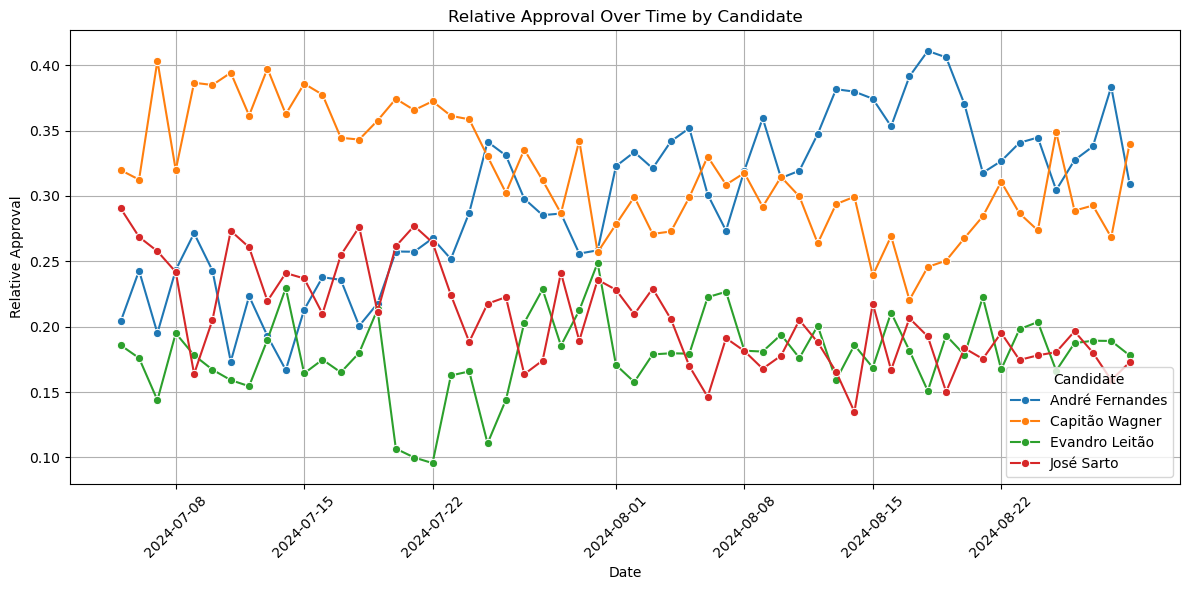

In [12]:
# Set the plot size
plt.figure(figsize=(12, 6))

# Create the line plot
sns.lineplot(data=res_final, x='dt', y='vote_intention', hue='Candidate', marker='o')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Relative Approval')  # Corrected label name for clarity
plt.title('Relative Approval Over Time by Candidate')  # Improved title for clarity

# Display the plot with enhancements
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)  # Add grid lines for better visual interpretation
plt.legend(title='Candidate')  # Add a legend with a title
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## Aprovação Relativa Acumulada


In [13]:
# Setting the alpha value for EWMA calculation
alpha = 2/(len(res_final)/3+1)  # Adjust as needed

# Compute EWMA for each candidate's predictions
def ewma_group(group, alpha=0.3):
    return group.ewm(alpha=alpha, adjust=False).mean()

# Ensure 'dt' is datetime if not already
res_final['dt'] = pd.to_datetime(res_final['dt'])

# Sort by candidate and dt to ensure calculations are done in the correct order
res_final = res_final.sort_values(by=['Candidate', 'dt'])

# Apply the EWMA calculation to each candidate's predictions
res_final['ewma_prediction'] = res_final.groupby('Candidate')['vote_intention'].transform(lambda x: ewma_group(x, alpha))


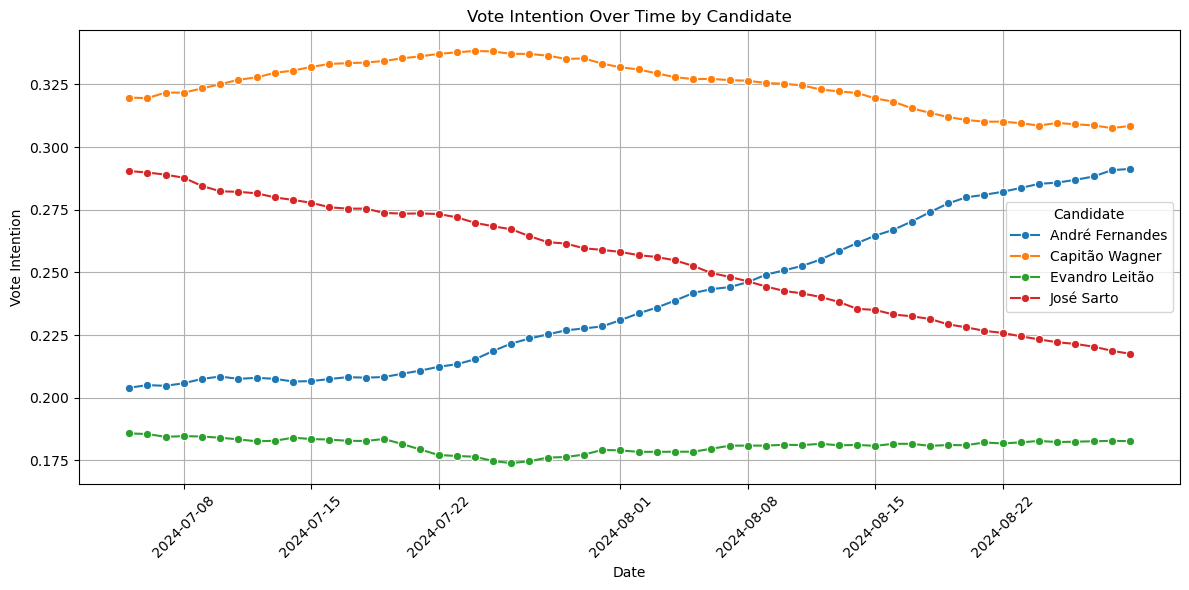

In [14]:
# Set the plot size
plt.figure(figsize=(12, 6))

# Create the line plot for the Exponentially Weighted Moving Average (EWMA) prediction
sns.lineplot(data=res_final, x='dt', y='ewma_prediction', hue='Candidate', marker='o')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Vote Intention')
plt.title('Vote Intention Over Time by Candidate')

# Enhance the plot display
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)           # Add grid lines for better visual interpretation
plt.legend(title='Candidate')  # Add a legend with a title
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()